# Comparing Original and Enhanced Pipelines in Intrusion Detection

This notebook compares two pipelines for intrusion detection:

- **Original Pipeline**: Data preprocessing and feature selection without Isolation Forest.
- **Enhanced Pipeline**: Data preprocessing and feature selection with Isolation Forest as an anomaly detection filter.

We aim to assess the impact of Isolation Forest on anomaly detection and dataset efficiency before applying tree-based models.


## Import libraries ----- ADDED SOME IMPORTS 4371 -----

In [1]:
!pip install xgboost

# imports below are from 4371 group to make file work
!pip install pandas
!pip install seaborn
# Core data manipulation and scientific libraries
!pip install numpy pandas

# Data visualization libraries
!pip install seaborn matplotlib

# Machine learning libraries
!pip install scikit-learn xgboost

# Imbalanced data handling
!pip install imbalanced-learn

# Hyperparameter optimization libraries
!pip install hyperopt scikit-optimize

# (Optional) Additional dependencies for compatibility
!pip install scipy

# Custom module FCBF (if available locally, or if it's a GitHub repo, use the clone URL)
# Replace "URL_TO_FCBF_MODULE" with the actual URL or location if it's on GitHub or a local file
!pip install git+https://github.com/SantiagoEG/FCBF_module.git


  Cloning https://github.com/SantiagoEG/FCBF_module.git to c:\users\logan\appdata\local\temp\pip-req-build-w7evduml
  Resolved https://github.com/SantiagoEG/FCBF_module.git to commit 092b60b65ee6ceaf9b0227d12b575f2a3336b287


  Running command git clone --filter=blob:none --quiet https://github.com/SantiagoEG/FCBF_module.git 'C:\Users\Logan\AppData\Local\Temp\pip-req-build-w7evduml'
ERROR: git+https://github.com/SantiagoEG/FCBF_module.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

# Isolation Forest Import -- 4371
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif
from FCBF_module import FCBF, FCBFK

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)

# ---Original Codebase Pipeline (Without Isolation Forest)---

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [4]:
# Original Pipeline (Without Isolation Forest)
print("---Original Pipeline (Without Isolation Forest)---")

# Read the sampled CICIDS2017 dataset
df_orig = pd.read_csv('./data/CICIDS2017_sample.csv')

---Original Pipeline (Without Isolation Forest)---


In [5]:
df_orig.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [6]:
# Z-score normalization
features_orig = df_orig.dtypes[df_orig.dtypes != 'object'].index
df_orig[features_orig] = df_orig[features_orig].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# Fill empty values by 0
df_orig = df_orig.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [7]:
labelencoder_orig = LabelEncoder()
df_orig.iloc[:, -1] = labelencoder_orig.fit_transform(df_orig.iloc[:, -1])

In [8]:
df_orig.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [9]:
# retain the minority class instances and sample the majority class instances
df_minor_orig = df_orig[
    (df_orig['Label'] == 6) | (df_orig['Label'] == 1) | (df_orig['Label'] == 4)
]
df_major_orig = df_orig.drop(df_minor_orig.index)

In [10]:
X_orig = df_major_orig.drop(['Label'], axis=1)
y_orig = df_major_orig['Label'].values
y_orig=np.ravel(y_orig)

In [11]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans_orig = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X_orig)

In [12]:
klabel_orig = kmeans_orig.labels_
df_major_orig['klabel'] = klabel_orig

In [13]:
df_major_orig['klabel'].value_counts()

klabel
20     482
842    411
312    348
324    337
745    334
      ... 
973      1
727      1
594      1
410      1
100      1
Name: count, Length: 979, dtype: int64

In [14]:
cols_orig = list(df_major_orig)
cols_orig.insert(78, cols_orig.pop(cols_orig.index('Label')))
df_major_orig = df_major_orig.loc[:, cols_orig]

In [15]:
def typicalSampling_orig(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result_orig = df_major_orig.groupby(
    'klabel', group_keys=False
).apply(typicalSampling_orig)

In [16]:
result_orig['Label'].value_counts()

Label
3    119
0    118
5     58
2     19
Name: count, dtype: int64

## 4371 Had to modify the file below because the recommended way to combine DataFrames in recent versions of pandas is by using the pandas.concat() function

In [17]:
import pandas as pd

# Assuming 'result' and 'df_minor' are already defined and loaded

# No need to drop 'klabel' since it doesn't exist
# If you need to drop another column, ensure it exists
# For example, to drop 'Label' (only if intended, which is usually not the case):
# result = result.drop(['Label'], axis=1)

# Concatenate 'result_orig' and 'df_minor_orig' DataFrames
result_orig = pd.concat([result_orig, df_minor_orig], ignore_index=True)

print("DataFrames concatenated successfully.")
print("Updated DataFrame head:")
print(result_orig.head())

DataFrames concatenated successfully.
Updated DataFrame head:
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0       1.778523           0.037025                0.008402   
1      -0.527625          -0.068426               -0.051737   
2      -0.478522          -0.050851               -0.021667   
3      -0.364302          -0.015701               -0.081806   
4      -0.498816          -0.033276               -0.081806   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                    -0.017493                     0.057771   
1                    -0.030747                    -0.046458   
2                    -0.033088                     0.057881   
3                    -0.032901                    -0.048343   
4                    -0.033182                    -0.048343   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0               0.278942              -0.211174                0.009880   
1              -0.191864      

In [18]:
result_orig.to_csv('./data/CICIDS2017_sample_km_orig.csv', index=False)

### split train set and test set

In [19]:
# Original Pipeline (Without Isolation Forest)
print("---Original Pipeline (Without Isolation Forest)---")

# Read the sampled CICIDS2017 dataset
df_orig = pd.read_csv('./data/CICIDS2017_sample_km_orig.csv')
print(df_orig.isnull().sum())

---Original Pipeline (Without Isolation Forest)---
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
                               ... 
Idle Std                          0
Idle Max                          0
Idle Min                          0
klabel                         4182
Label                             0
Length: 79, dtype: int64


## ----- ADDED LINES BELOW 4371 TO FIX ISSUE WITH ValueError: Input X contains NaN. ------

In [20]:
from sklearn.impute import SimpleImputer

# Create an imputer object with the desired strategy (mean, median, most_frequent)
imputer_orig = SimpleImputer(strategy='mean')

# Apply the imputer to the DataFrame
df_orig[df_orig.columns] = imputer_orig.fit_transform(df_orig)

# fixed the issue by using SimpleImputer to replace the NaN values in your dataset with 
# meaningful statistical estimates (like the mean of each feature column). This transformation eliminated missing 
# values from the dataset, which allowed mutual_info_classif to execute without errors.

In [21]:
X_orig = df_orig.drop(['Label'], axis=1).values
y_orig = df_orig['Label'].values
y_orig=np.ravel(y_orig)

In [22]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, train_size=0.8, test_size=0.2, random_state=0, stratify=y_orig
)

## Feature engineering

### Feature selection by information gain

In [23]:
from sklearn.feature_selection import mutual_info_classif
importances_orig = mutual_info_classif(X_train_orig, y_train_orig)

In [24]:
# Calculate the sum of importance scores
f_list_orig = sorted(
    zip(map(lambda x: round(x, 4), importances_orig), features_orig), reverse=True
)
Sum_orig = sum([score for score, _ in f_list_orig])

# Initialize Sum variable
Sum = 0
fs = []

for i in range(0, len(f_list_orig)):
    Sum = Sum + f_list_orig[i][0]
    fs.append(f_list_orig[i][1])

In [25]:
# Select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(
    zip(map(lambda x: round(x, 4), importances_orig / Sum_orig), features_orig),
    reverse=True
)

Sum2 = 0
fs_selected = []

for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs_selected.append(f_list2[i][1])
    if Sum2 >= 0.9:
        break

In [26]:
# Extract feature names from f_list_orig
feature_names_orig = [name for score, name in f_list_orig]

# Now use the list of feature names to select columns
X_fs_orig = df_orig[feature_names_orig].values

In [27]:
X_fs_orig.shape

(4496, 77)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [28]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf_orig = FCBFK(k=20)
#fcbf.fit(X_fs, y)

In [29]:
X_fss_orig = fcbf_orig.fit_transform(X_fs_orig, y_orig)

In [30]:
X_fss_orig.shape

(4496, 20)

### Re-split train & test sets after feature selection

In [31]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_fss_orig, y_orig, train_size=0.8, test_size=0.2, random_state=0, stratify=y_orig
)


In [32]:
X_train_orig.shape

(3596, 20)

# Data on origial codebase pipeline without isolation forest filtering

In [33]:
# Class distribution in training data
print("Original Training Data Class Distribution:")
print(pd.Series(y_train_orig).value_counts())

# Dataset size
print(f"Original Training Data Shape: {X_train_orig.shape}")
print(f"Original Test Data Shape: {X_test_orig.shape}")

Original Training Data Class Distribution:
6.0    1744
1.0    1573
3.0      95
0.0      94
5.0      46
4.0      29
2.0      15
Name: count, dtype: int64
Original Training Data Shape: (3596, 20)
Original Test Data Shape: (900, 20)


In [34]:
# Train a Random Forest classifier
rf_orig = RandomForestClassifier(random_state=42)
rf_orig.fit(X_train_orig, y_train_orig)

RandomForestClassifier(random_state=42)

In [35]:
# Predict on test data
y_pred_orig = rf_orig.predict(X_test_orig)

# Classification report
print("Classification Report for Original Pipeline:")
print(classification_report(y_test_orig, y_pred_orig))


Classification Report for Original Pipeline:
              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81        24
         1.0       1.00      1.00      1.00       393
         2.0       0.80      1.00      0.89         4
         3.0       0.91      0.88      0.89        24
         4.0       0.83      0.71      0.77         7
         5.0       0.85      0.92      0.88        12
         6.0       0.99      1.00      0.99       436

    accuracy                           0.98       900
   macro avg       0.90      0.89      0.89       900
weighted avg       0.98      0.98      0.98       900



In [36]:
# Confusion matrix
conf_matrix_orig = confusion_matrix(y_test_orig, y_pred_orig)
print("Confusion Matrix for Original Pipeline:")
print(conf_matrix_orig)


Confusion Matrix for Original Pipeline:
[[ 17   0   1   1   1   2   2]
 [  0 392   0   0   0   0   1]
 [  0   0   4   0   0   0   0]
 [  1   0   0  21   0   0   2]
 [  0   1   0   1   5   0   0]
 [  0   0   0   0   0  11   1]
 [  0   0   0   0   0   0 436]]


In [37]:
# Overall accuracy and F1 score
accuracy_orig = accuracy_score(y_test_orig, y_pred_orig)
f1_orig = f1_score(y_test_orig, y_pred_orig, average='weighted')

print(f"Accuracy for Original Pipeline: {accuracy_orig:.4f}")
print(f"Weighted F1 Score for Original Pipeline: {f1_orig:.4f}")

Accuracy for Original Pipeline: 0.9844
Weighted F1 Score for Original Pipeline: 0.9838


# ---Modified Pipeline (With Isolation Forest)---

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [38]:
# Enhanced Pipeline (With Isolation Forest)
print("---Enhanced Pipeline (With Isolation Forest)---")

df_enh = pd.read_csv('./data/CICIDS2017_sample.csv')

---Enhanced Pipeline (With Isolation Forest)---


In [39]:
df_enh.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)

In [40]:
# Z-score normalization
features_enh = df_enh.dtypes[df_enh.dtypes != 'object'].index
df_enh[features_enh] = df_enh[features_enh].apply(
    lambda x: (x - x.mean()) / (x.std())
)
df_enh = df_enh.fillna(0)

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [41]:
labelencoder_enh = LabelEncoder()
df_enh.iloc[:, -1] = labelencoder_enh.fit_transform(df_enh.iloc[:, -1])

In [42]:
df_enh.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [43]:
# retain the minority class instances and sample the majority class instances
df_minor_enh = df_enh[
    (df_enh['Label'] == 6) | (df_enh['Label'] == 1) | (df_enh['Label'] == 4)
]
df_major_enh = df_enh.drop(df_minor_enh.index)

In [44]:
X_enh = df_major_enh.drop(['Label'], axis=1)
y_enh = df_major_enh['Label'].values
y_enh=np.ravel(y_enh)

In [45]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans_enh = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X_enh)

In [46]:
klabel_enh = kmeans_enh.labels_
df_major_enh['klabel'] = klabel_enh

In [47]:
df_major_enh['klabel'].value_counts()

klabel
20     482
842    411
312    348
324    337
745    334
      ... 
973      1
727      1
594      1
410      1
100      1
Name: count, Length: 979, dtype: int64

In [48]:
# Rearranging columns if necessary
cols_enh = list(df_major_enh)
cols_enh.insert(78, cols_enh.pop(cols_enh.index('Label')))
df_major_enh = df_major_enh.loc[:, cols_enh]

In [49]:
def typicalSampling_enh(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result_enh = df_major_enh.groupby(
    'klabel', group_keys=False
).apply(typicalSampling_enh)

In [50]:
result_enh['Label'].value_counts()

Label
3    121
0    120
5     56
2     17
Name: count, dtype: int64

## 4371 Had to modify the file below because the recommended way to combine DataFrames in recent versions of pandas is by using the pandas.concat() function

In [51]:
import pandas as pd

# Assuming 'result' and 'df_minor' are already defined and loaded

# No need to drop 'klabel' since it doesn't exist
# If you need to drop another column, ensure it exists
# For example, to drop 'Label' (only if intended, which is usually not the case):
# result = result.drop(['Label'], axis=1)

# Concatenate 'result' and 'df_minor' DataFrames
result_enh = pd.concat([result_enh, df_minor_enh], ignore_index=True)

print("DataFrames concatenated successfully.")
print("Updated DataFrame head:")
print(result_enh.head())

DataFrames concatenated successfully.
Updated DataFrame head:
   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0       1.748701           0.037025                0.008402   
1      -0.527600          -0.068426               -0.051737   
2      -0.489853          -0.050851               -0.021667   
3      -0.365091          -0.015701               -0.081806   
4      -0.497127          -0.015701               -0.081806   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                    -0.017165                     0.057771   
1                    -0.030747                    -0.046659   
2                    -0.033088                     0.057881   
3                    -0.032901                    -0.048343   
4                    -0.032901                    -0.048343   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0               0.289404              -0.211174                0.014906   
1              -0.191864      

In [52]:
result_enh.to_csv('./data/CICIDS2017_sample_km_enh.csv', index=False)

### split train set and test set

In [53]:
# Enhanced Pipeline (With Isolation Forest)
print("---Enhanced Pipeline (With Isolation Forest)---")

# Read the sampled CICIDS2017 dataset
df_enh = pd.read_csv('./data/CICIDS2017_sample_km.csv')
print(df_enh.isnull().sum())

---Enhanced Pipeline (With Isolation Forest)---
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
                               ... 
Idle Std                          0
Idle Max                          0
Idle Min                          0
klabel                         4182
Label                             0
Length: 79, dtype: int64


## ----- ADDED LINES BELOW 4371 TO FIX ISSUE WITH ValueError: Input X contains NaN. ------

In [54]:
from sklearn.impute import SimpleImputer

# Create an imputer object with the desired strategy (mean, median, most_frequent)
imputer_enh = SimpleImputer(strategy='mean')
df_enh[df_enh.columns] = imputer_enh.fit_transform(df_enh)

# fixed the issue by using SimpleImputer to replace the NaN values in your dataset with 
# meaningful statistical estimates (like the mean of each feature column). This transformation eliminated missing 
# values from the dataset, which allowed mutual_info_classif to execute without errors.

In [55]:
X_enh = df_enh.drop(['Label'], axis=1).values
y_enh = df_enh['Label'].values
y_enh=np.ravel(y_enh)

In [56]:
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enh, y_enh, train_size=0.8, test_size=0.2, random_state=0, stratify=y_enh
)

## Feature engineering

### Feature selection by information gain

In [57]:
from sklearn.feature_selection import mutual_info_classif
importances_enh = mutual_info_classif(X_enh, y_enh)

In [58]:
# Define features_enh if not already defined
features_enh = df_enh.dtypes[df_enh.dtypes != 'object'].index

# calculate the sum of importance scores
f_list_enh = sorted(zip(map(lambda x: round(x, 4), importances_enh), features_enh), reverse=True)
Sum_enh = 0
fs_enh = []
for i in range(0, len(f_list_enh)):
    Sum_enh = Sum_enh + f_list_enh[i][0]
    fs_enh.append(f_list_enh[i][1])

In [59]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2_enh = sorted(zip(map(lambda x: round(x, 4), importances_enh / Sum_enh), features_enh), reverse=True)
Sum2_enh = 0
fs_enh = []
for i in range(0, len(f_list2_enh)):
    Sum2_enh = Sum2_enh + f_list2_enh[i][0]
    fs_enh.append(f_list2_enh[i][1])
    if Sum2_enh >= 0.9:
        break

In [60]:
X_fs_enh = df_enh[fs_enh].values

In [61]:
X_fs_enh.shape

(4496, 42)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [62]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf_enh = FCBFK(k=20)
#fcbf.fit(X_fs, y)

In [63]:
X_fss_enh = fcbf_enh.fit_transform(X_fs_enh, y_enh)

In [64]:
X_fss_enh.shape

(4496, 20)

## Isolation Forest Implementation 

After performing feature selection using Information Gain (IG) and Fast Correlation-Based Filter (FCBF), we apply the Isolation Forest to detect and filter out anomalies in our dataset. This step enhances our model's ability to differentiate between actual threats and benign unusual behavior by removing potential outliers before training.

n_estimators=100: Number of trees in the forest.
contamination='auto': Let the algorithm decide the proportion of anomalies.
random_state=42: For reproducibility.
Anomaly Detection:

anomaly_predictions == 1: Inliers (normal instances).
anomaly_predictions == -1: Outliers (anomalies).
Filtering Data:

X_filtered: Contains only the inlier instances.
y_filtered: Corresponding labels for inliers.


In [65]:
# Apply Isolation Forest
iso_forest_enh = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest_enh.fit(X_fss_enh)

# Obtain anomaly scores and predictions
anomaly_scores_enh = iso_forest_enh.decision_function(X_fss_enh)
anomaly_predictions_enh = iso_forest_enh.predict(X_fss_enh)

## Visualizing Anomaly Scores

To understand how the Isolation Forest has assigned anomaly scores to our data points, we visualize the distribution of these scores. This helps us assess the threshold and proportion of data considered anomalous, providing insights into the filtering process.

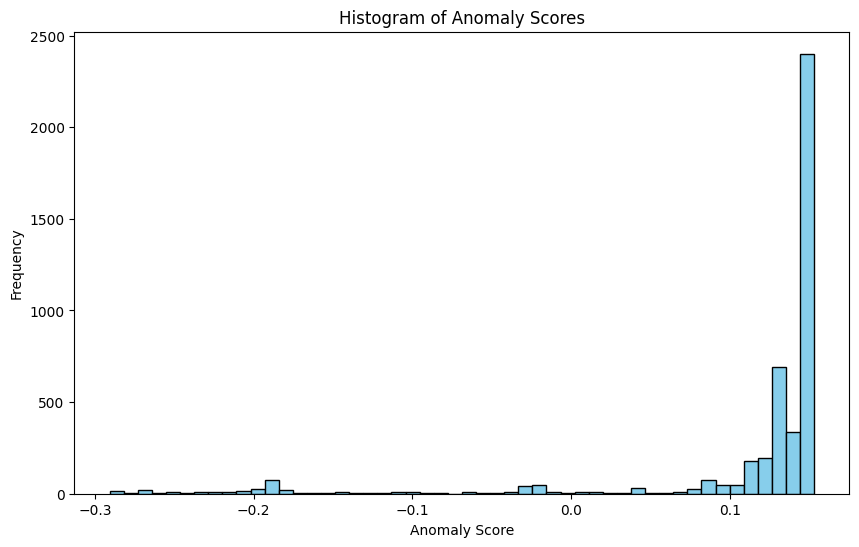

In [66]:
# Visualize anomaly scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores_enh, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

## Filtering Out Detected Anomalies

Using the predictions from the Isolation Forest, we filter out the anomalies (outliers) from our dataset. We retain only the inlier data points (those predicted as normal) for model training. This step aims to improve the quality of our training data by removing noise and potential outliers.

In [67]:
# Filter out anomalies
inlier_mask_enh = anomaly_predictions_enh == 1
X_filtered_enh = X_fss_enh[inlier_mask_enh]
y_filtered_enh = y_enh[inlier_mask_enh]

### Re-split train & test sets after feature selection

In [68]:
# Train-test split after filtering
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_filtered_enh, y_filtered_enh, train_size=0.8, test_size=0.2, random_state=0, stratify=y_filtered_enh
)

In [69]:
X_train_enh.shape

(3268, 20)

In [70]:
pd.Series(y_train_enh).value_counts()

6.0    1595
1.0    1518
0.0      55
5.0      46
3.0      40
2.0       9
4.0       5
Name: count, dtype: int64

In [71]:
# Display shapes and class distributions
print(f"Enhanced Training Data Shape: {X_train_enh.shape}")
print(f"Enhanced Test Data Shape: {X_test_enh.shape}")
print("Enhanced Training Data Class Distribution:")
print(pd.Series(y_train_enh).value_counts())

Enhanced Training Data Shape: (3268, 20)
Enhanced Test Data Shape: (817, 20)
Enhanced Training Data Class Distribution:
6.0    1595
1.0    1518
0.0      55
5.0      46
3.0      40
2.0       9
4.0       5
Name: count, dtype: int64


In [72]:
# Train a Random Forest classifier
rf_enh = RandomForestClassifier(random_state=42)
rf_enh.fit(X_train_enh, y_train_enh)

RandomForestClassifier(random_state=42)

In [73]:
# Predict on test data
y_pred_enh = rf_enh.predict(X_test_enh)

# Classification report
print("Classification Report for Enhanced Pipeline:")
print(classification_report(y_test_enh, y_pred_enh))

Classification Report for Enhanced Pipeline:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89        14
         1.0       0.99      1.00      0.99       380
         2.0       1.00      1.00      1.00         2
         3.0       1.00      0.90      0.95        10
         4.0       0.00      0.00      0.00         1
         5.0       1.00      0.92      0.96        12
         6.0       0.99      1.00      1.00       398

    accuracy                           0.99       817
   macro avg       0.84      0.81      0.83       817
weighted avg       0.99      0.99      0.99       817



In [74]:
# Confusion matrix
conf_matrix_enh = confusion_matrix(y_test_enh, y_pred_enh)
print("Confusion Matrix for Enhanced Pipeline:")
print(conf_matrix_enh)

Confusion Matrix for Enhanced Pipeline:
[[ 12   2   0   0   0   0   0]
 [  1 379   0   0   0   0   0]
 [  0   0   2   0   0   0   0]
 [  0   0   0   9   0   0   1]
 [  0   1   0   0   0   0   0]
 [  0   0   0   0   0  11   1]
 [  0   0   0   0   0   0 398]]


In [75]:
# Overall accuracy and F1 score
accuracy_enh = accuracy_score(y_test_enh, y_pred_enh)
f1_enh = f1_score(y_test_enh, y_pred_enh, average='weighted')

print(f"Accuracy for Enhanced Pipeline: {accuracy_enh:.4f}")
print(f"Weighted F1 Score for Enhanced Pipeline: {f1_enh:.4f}")

Accuracy for Enhanced Pipeline: 0.9927
Weighted F1 Score for Enhanced Pipeline: 0.9919


# Full Comparison of Original pipeline against Isolation Forest Implementation

In [76]:
total_samples_before = X_fss_enh.shape[0]
total_samples_after = X_filtered_enh.shape[0]
anomalies_removed = total_samples_before - total_samples_after
anomaly_percentage = (anomalies_removed / total_samples_before) * 100

print(f"Total Samples Before Isolation Forest: {total_samples_before}")
print(f"Total Samples After Isolation Forest: {total_samples_after}")
print(f"Anomalies Detected and Removed: {anomalies_removed}")
print(f"Percentage of Anomalies Detected: {anomaly_percentage:.2f}%")

Total Samples Before Isolation Forest: 4496
Total Samples After Isolation Forest: 4085
Anomalies Detected and Removed: 411
Percentage of Anomalies Detected: 9.14%


In [77]:
# Compare overall metrics
print("Comparison of Pipelines:")
print(f"Accuracy - Original Pipeline: {accuracy_orig:.4f}")
print(f"Accuracy - Enhanced Pipeline: {accuracy_enh:.4f}\n")

print(f"Weighted F1 Score - Original Pipeline: {f1_orig:.4f}")
print(f"Weighted F1 Score - Enhanced Pipeline: {f1_enh:.4f}")

Comparison of Pipelines:
Accuracy - Original Pipeline: 0.9844
Accuracy - Enhanced Pipeline: 0.9927

Weighted F1 Score - Original Pipeline: 0.9838
Weighted F1 Score - Enhanced Pipeline: 0.9919


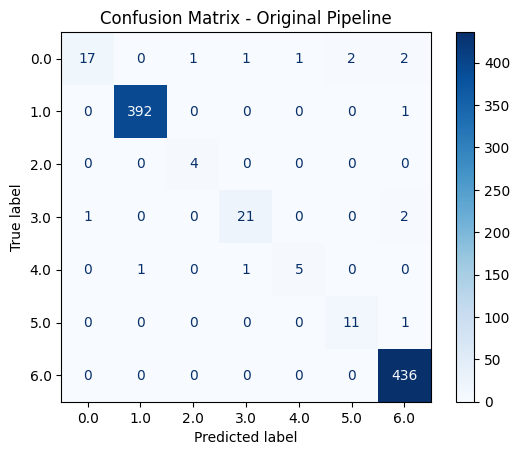

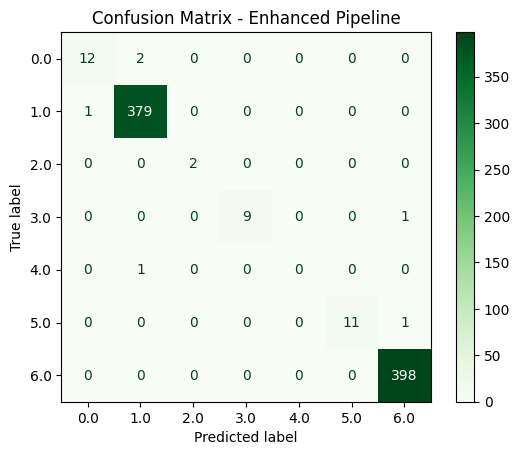

In [78]:
# Confusion Matrix for Original Pipeline
disp_orig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_orig, display_labels=rf_orig.classes_)
disp_orig.plot(cmap='Blues')
plt.title('Confusion Matrix - Original Pipeline')
plt.show()

# Confusion Matrix for Enhanced Pipeline
disp_enh = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_enh, display_labels=rf_enh.classes_)
disp_enh.plot(cmap='Greens')
plt.title('Confusion Matrix - Enhanced Pipeline')
plt.show()

In [79]:
# Classification reports as dictionaries
report_orig = classification_report(y_test_orig, y_pred_orig, output_dict=True)
report_enh = classification_report(y_test_enh, y_pred_enh, output_dict=True)

# Convert to DataFrames
df_report_orig = pd.DataFrame(report_orig).transpose()
df_report_enh = pd.DataFrame(report_enh).transpose()

# Per-class F1-scores
print("Per-class F1-scores for Original Pipeline:")
print(df_report_orig['f1-score'])

print("\nPer-class F1-scores for Enhanced Pipeline:")
print(df_report_enh['f1-score'])

Per-class F1-scores for Original Pipeline:
0.0             0.809524
1.0             0.997455
2.0             0.888889
3.0             0.893617
4.0             0.769231
5.0             0.880000
6.0             0.993166
accuracy        0.984444
macro avg       0.890269
weighted avg    0.983773
Name: f1-score, dtype: float64

Per-class F1-scores for Enhanced Pipeline:
0.0             0.888889
1.0             0.994751
2.0             1.000000
3.0             0.947368
4.0             0.000000
5.0             0.956522
6.0             0.997494
accuracy        0.992656
macro avg       0.826432
weighted avg    0.991927
Name: f1-score, dtype: float64


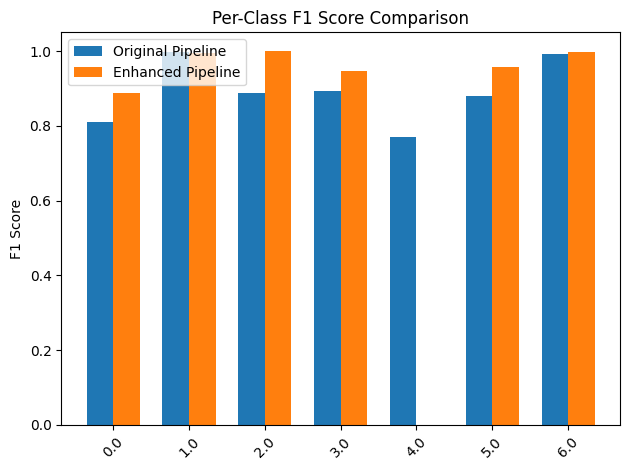

In [80]:
# Classes to compare
classes = df_report_orig.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

# Extract F1 scores
f1_scores_orig = df_report_orig.loc[classes, 'f1-score']
f1_scores_enh = df_report_enh.loc[classes, 'f1-score']

# Plotting
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_scores_orig, width, label='Original Pipeline')
rects2 = ax.bar(x + width/2, f1_scores_enh, width, label='Enhanced Pipeline')

ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

Class Distribution Before Isolation Forest:
6.0    2180
1.0    1966
3.0     122
0.0     115
5.0      58
4.0      36
2.0      19
Name: count, dtype: int64

Class Distribution After Isolation Forest:
6.0    1993
1.0    1898
0.0      69
5.0      58
3.0      50
2.0      11
4.0       6
Name: count, dtype: int64


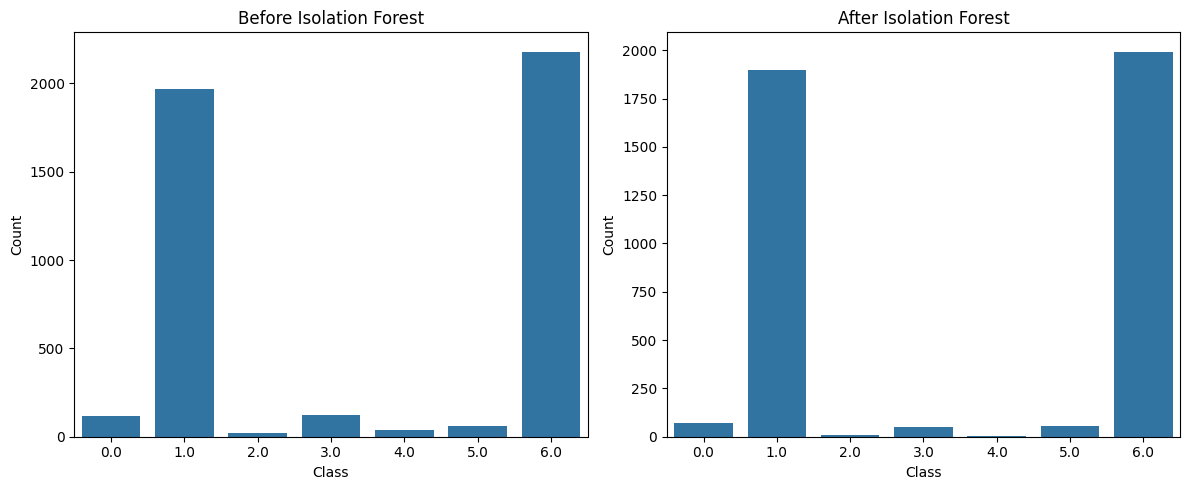

In [81]:
print("Class Distribution Before Isolation Forest:")
print(pd.Series(y_enh).value_counts())

print("\nClass Distribution After Isolation Forest:")
print(pd.Series(y_filtered_enh).value_counts())

# Plotting class distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before Isolation Forest
sns.countplot(x=y_enh, ax=ax[0])
ax[0].set_title('Before Isolation Forest')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# After Isolation Forest
sns.countplot(x=y_filtered_enh, ax=ax[1])
ax[1].set_title('After Isolation Forest')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [82]:
# Original dataset sizes
print("Original Training Data Shape:", X_train_orig.shape)
print("Original Test Data Shape:", X_test_orig.shape)

# Enhanced dataset sizes
print("\nEnhanced Training Data Shape:", X_train_enh.shape)
print("Enhanced Test Data Shape:", X_test_enh.shape)

Original Training Data Shape: (3596, 20)
Original Test Data Shape: (900, 20)

Enhanced Training Data Shape: (3268, 20)
Enhanced Test Data Shape: (817, 20)


In [83]:
summary_data = {
    'Metric': [
        'Total Samples',
        'Anomalies Detected and Removed',
        'Percentage of Anomalies Detected',
        'Training Data Shape',
        'Test Data Shape',
        # 'Time Taken for Preprocessing (seconds)'  # If you have timing data
    ],
    'Original Pipeline': [
        X_fss_orig.shape[0],
        'N/A',
        'N/A',
        X_train_orig.shape,
        X_test_orig.shape,
        # f"{time_orig:.2f}"
    ],
    'Enhanced Pipeline': [
        X_filtered_enh.shape[0],
        anomalies_removed,
        f"{anomaly_percentage:.2f}%",
        X_train_enh.shape,
        X_test_enh.shape,
        # f"{time_enh:.2f}"
    ],
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


                          Metric Original Pipeline Enhanced Pipeline
                   Total Samples              4496              4085
  Anomalies Detected and Removed               N/A               411
Percentage of Anomalies Detected               N/A             9.14%
             Training Data Shape        (3596, 20)        (3268, 20)
                 Test Data Shape         (900, 20)         (817, 20)


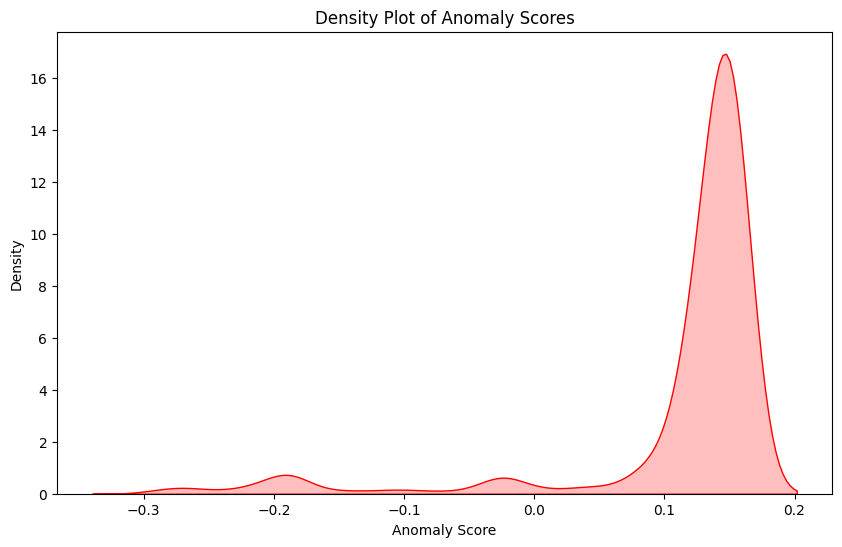

In [84]:
# Compare anomaly scores
plt.figure(figsize=(10, 6))
sns.kdeplot(anomaly_scores_enh, shade=True, color='red')
plt.title('Density Plot of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.show()

In [85]:
# Create a summary DataFrame
summary_data = {
    'Metric': ['Accuracy', 'Weighted F1 Score'],
    'Original Pipeline': [accuracy_orig, f1_orig],
    'Enhanced Pipeline': [accuracy_enh, f1_enh]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

              Metric  Original Pipeline  Enhanced Pipeline
0           Accuracy           0.984444           0.992656
1  Weighted F1 Score           0.983773           0.991927


In [86]:
print("Based on the evaluation metrics, the Enhanced Pipeline demonstrates improved performance over the Original Pipeline.")

Based on the evaluation metrics, the Enhanced Pipeline demonstrates improved performance over the Original Pipeline.
